In [2]:
import pandas as pd
import numpy as np
import re

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import tensorflow as tf

model_path = '/content/drive/My Drive/Javeriana/Medical_Error_Detection/Modelos/Pruebas_Rendimiento/Modelos_Descarga/TF_Models/my_nlp_model_tf'
model = tf.keras.models.load_model(model_path)


In [4]:
import json
from tensorflow.keras.preprocessing.text import tokenizer_from_json

tokenizer_path = '/content/drive/My Drive/Javeriana/Medical_Error_Detection/Modelos/Pruebas_Rendimiento/Modelos_Descarga/TF_Models/gru_v5.json'

with open(tokenizer_path) as f:
    data = json.load(f)
    tokenizer = tokenizer_from_json(data)


In [5]:
from google.colab import files
uploaded = files.upload()

Saving MEDIQA-CORR-2024-MS-ValidationSet-1-Full.csv to MEDIQA-CORR-2024-MS-ValidationSet-1-Full.csv


In [6]:
df = pd.read_csv('MEDIQA-CORR-2024-MS-ValidationSet-1-Full.csv', delimiter=',', encoding='utf-8')
# df= df.drop(['Error Sentence ID', 'Error Sentence', 'Corrected Sentence', 'Corrected Text'], axis=1)
df.head()

,Unnamed: 0,Text ID,Text,Sentences,Error Flag,Error Sentence ID,Error Sentence,Corrected Sentence,Corrected Text
0,0,ms-val-0,A 24-year-old woman comes to the emergency dep...,0 A 24-year-old woman comes to the emergency d...,1,5,Culture tests indicate Neisseria gonorrhoeae.,Culture tests indicate Trichomonas vaginalis.,A 24-year-old woman comes to the emergency dep...
1,1,ms-val-1,A 24-year-old woman comes to the emergency dep...,0 A 24-year-old woman comes to the emergency d...,0,-1,NaN,NaN,NaN
2,2,ms-val-2,A 43-year-old woman comes to the physician bec...,0 A 43-year-old woman comes to the physician b...,1,24,Pathology confirms Streptococcus pneumoniae is...,Pathology confirms Mycoplasma pneumoniae is th...,A 43-year-old woman comes to the physician bec...
3,3,ms-val-3,A 4-year-old is brought into the emeregency ro...,0 A 4-year-old is brought into the emeregency ...,1,4,Laboratory studies confirm that he has a respi...,Laboratory studies confirm that he has parainf...,A 4-year-old is brought into the emeregency ro...
4,4,ms-val-4,A previously healthy 25-year-old man comes to ...,0 A previously healthy 25-year-old man comes t...,1,0,A previously healthy 25-year-old man comes to ...,A previously healthy 25-year-old man comes to ...,A previously healthy 25-year-old man comes to ...


In [7]:
from gensim.models import KeyedVectors

bioWordVecPath = '/content/drive/My Drive/Javeriana/Medical_Error_Detection/Modelos/Red_Neuronal_GRU/BioWordVec_PubMed_MIMICIII_d200.vec.bin'
model_bioWordVec = KeyedVectors.load_word2vec_format(bioWordVecPath, binary=True)

In [8]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Preparar los textos para el modelo
texts = df['Text'].values
labels = df['Error Flag'].values

In [9]:
def map_to_bioWordVec(sequence, tokenizer, model_bioWordVec, max_length):
    embeddings = np.zeros((max_length, 200))  # Ajusta 200 según la dimensión de tu BioWordVec
    for i, word_index in enumerate(sequence):
        if i >= max_length:
            break
        word = tokenizer.index_word.get(word_index, None)
        if word and word in model_bioWordVec:
            embeddings[i] = model_bioWordVec[word]
        else:
            embeddings[i] = np.zeros(200)  # Vector de ceros para palabras fuera del vocabulario
    return embeddings

In [10]:
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=200, padding='post', truncating='post')  # Asegúrate de que `maxlen` corresponde al usado durante el entrenamiento

In [11]:
# Transformar a vectores BioWordVec
X_new_bioWordVec = np.array([map_to_bioWordVec(seq, tokenizer, model_bioWordVec, max_length=200) for seq in padded_sequences])  # Asegúrate de que `max_length` sea el correcto


In [13]:
# Realizar predicciones
predictions = model.predict(X_new_bioWordVec)


18/18 [==============================] - 3s 99ms/step


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import numpy as np

predicted_labels = np.round(predictions).astype(int)

# Asegurarte de que las etiquetas verdaderas también sean enteros si no lo son ya
true_labels = labels.astype(int)

# Ahora calcular las métricas
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy on new data: {accuracy}")
print(f"Precision on new data: {precision}")
print(f"Recall on new data: {recall}")
print(f"F1 Score on new data: {f1}")


Accuracy on new data: 0.5557491289198606
Precision on new data: 0.5316440785150098
Recall on new data: 0.5557491289198606
F1 Score on new data: 0.41485731278714855


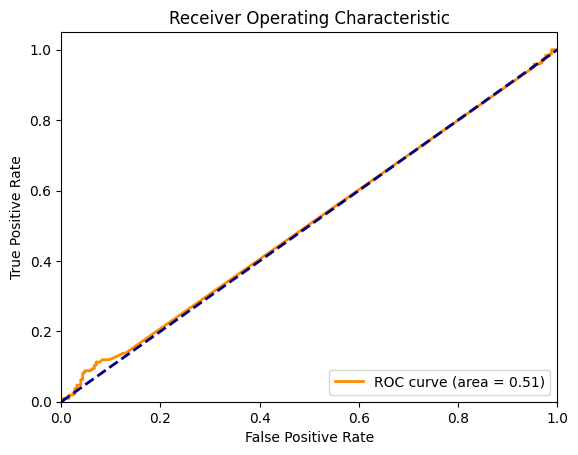

In [15]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calcular la tasa de verdaderos positivos (TPR), la tasa de falsos positivos (FPR), y los umbrales
fpr, tpr, thresholds = roc_curve(true_labels, predictions)

# Calcular el área bajo la curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# Generar la gráfica
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [18]:
df= df.drop(['Error Flag'], axis=1)

# Convertir probabilidades en etiquetas binarias usando un umbral de 0.5
df['Error Flag Pred'] = (predictions >= 0.5).astype(int)

# Renombrar la columna 'Error Flag Pred' a 'Error Flag'
df.rename(columns={'Error Flag Pred': 'Error Flag'}, inplace=True)

# Seleccionar y conservar únicamente las columnas deseadas
df_final = df[['Text ID', 'Error Flag', 'Error Sentence ID', 'Corrected Sentence']]

# Mostrar las primeras filas del DataFrame final para verificar
print(df_final.head())


    Text ID  Error Flag  Error Sentence ID  \
0  ms-val-0           1                  5   
1  ms-val-1           1                 -1   
2  ms-val-2           1                 24   
3  ms-val-3           1                  4   
4  ms-val-4           1                  0   

                                  Corrected Sentence  
0      Culture tests indicate Trichomonas vaginalis.  
1                                                NaN  
2  Pathology confirms Mycoplasma pneumoniae is th...  
3  Laboratory studies confirm that he has parainf...  
4  A previously healthy 25-year-old man comes to ...  


In [21]:
df_final['Error Flag'].value_counts()

1    562
0     12
Name: Error Flag, dtype: int64

In [22]:
df_final['formatted'] = df_final.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

# Asegurar un solo espacio entre palabras, incluso si hay múltiples espacios originalmente
df_final['formatted'] = df_final['formatted'].apply(lambda x: ' '.join(x.split()))

# Guardar el DataFrame modificado a un archivo de texto sin comillas y con un solo espacio
with open('prediction_Gru.txt', 'w', encoding='utf-8') as file:
    for item in df_final['formatted']:
        file.write("%s\n" % item)

# Importar la función de descarga de archivos de Colab
from google.colab import files

# Descargar el archivo de texto a tu computadora
files.download('prediction_Gru.txt')

<ipython-input-22-878568ad3ac1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['formatted'] = df_final.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
<ipython-input-22-878568ad3ac1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['formatted'] = df_final['formatted'].apply(lambda x: ' '.join(x.split()))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>